# 1. Fraud Detection with Autoencoders by Using Reconstruction Error


To detect anomalies, an autoencoder should be trained in an unsupervised (or semi-supervised) manner using data that is free of anomalies. Once the model is trained, it is employed to predict normal data mixed with anomalies. Instances where the model fails to make accurate predictions are identified and marked as anomalies

## Setup


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import h5py
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns

## Loading the data

In [4]:
df = pd.read_csv('../input/creditcardfraud/creditcard.csv')

## EDA

Explore the data.

In [5]:
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The file contains 31 columns of which 3 are Time, Amount and class. The rest are features transformed by PCA. 

Check for missing values:

In [6]:
df.isnull().values.any()

False

<Axes: >

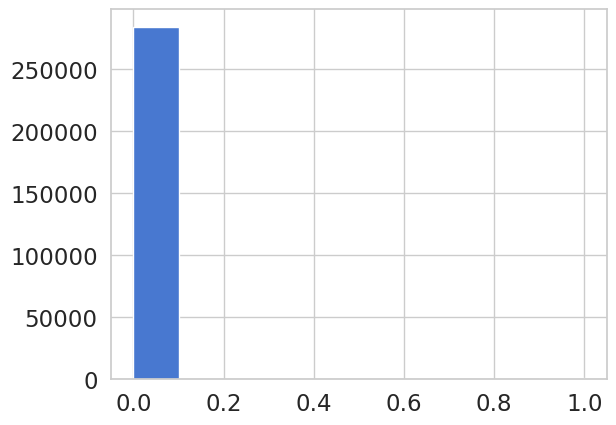

In [7]:
df.Class.hist()

Check how large are the classes.

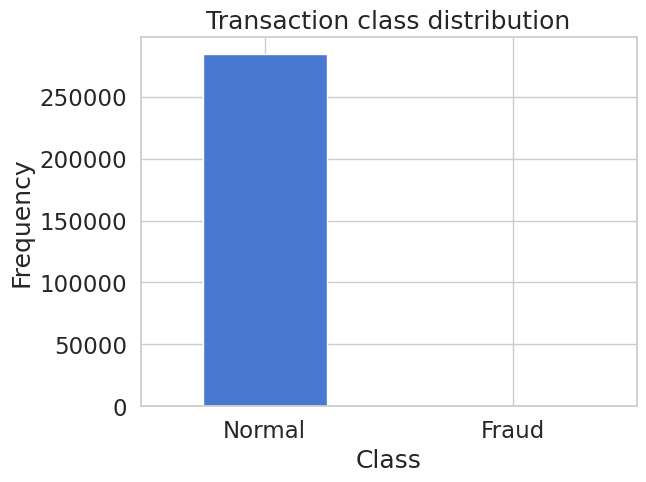

In [8]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
rcParams['figure.figsize'] = 14, 8
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

The dataset is highly imbalanced: it has a lot more normal transactions than fraudulent ones.  

Create subsets by class variable:

In [9]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [10]:
frauds.shape

(492, 31)

In [11]:
normal.shape

(284315, 31)

How different are the amounts of money used in different transaction classes?

In [12]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [13]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Summary statistics are not equivalent, but they do not seem to be different enough to draw reliable conclusions.

Both distributions look like exponential. Compare rough estimates of intensity parameters of exponential distributions of amounts:

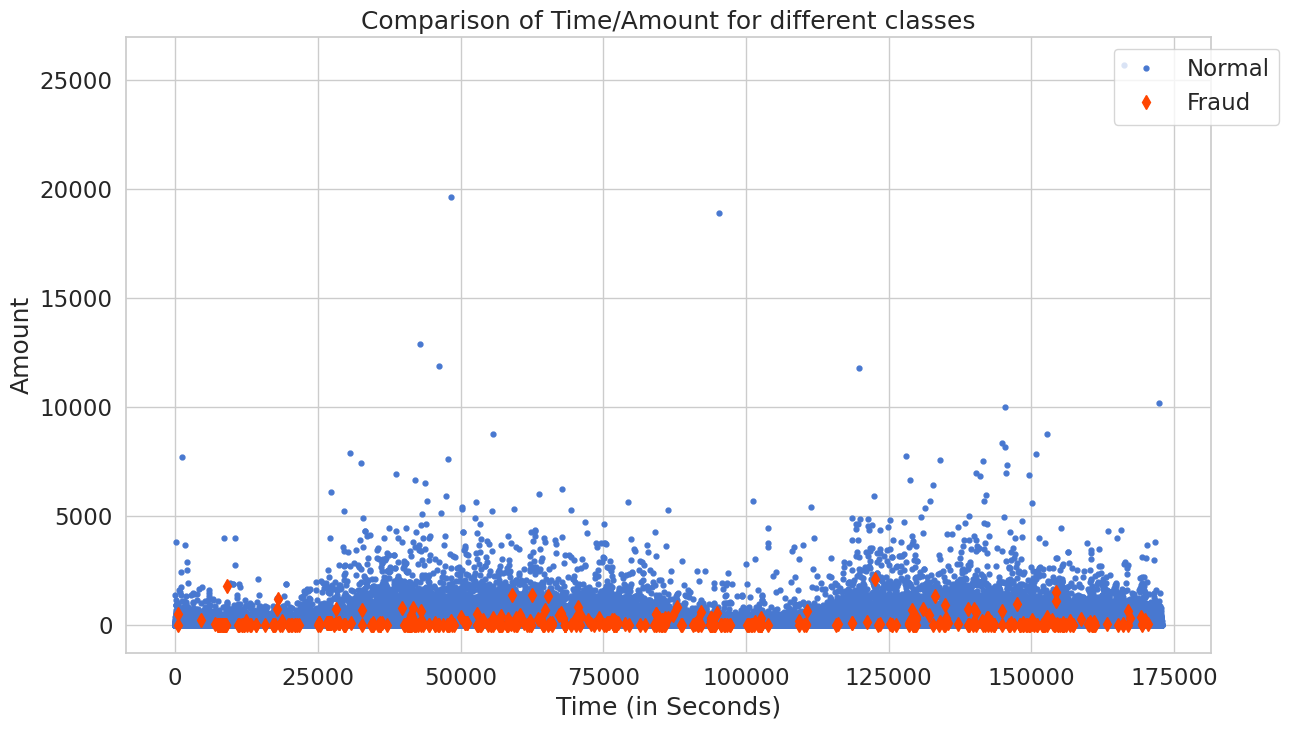

In [14]:
groups = df.groupby('Class')
fig, ax = plt.subplots()
for name, group in groups:
     if name == 1:
         MarkerSize = 7
         Color = 'orangered'
         Label = 'Fraud'
         Marker = 'd'
     else:
         MarkerSize = 3.5
         Color = 'b'
         Label = 'Normal'
         Marker = 'o'
     ax.plot(group.Time, group.Amount,
             linestyle='',
             color=Color,
             label=Label,
             ms=MarkerSize,
             marker=Marker)
ax.legend(loc='upper left', bbox_to_anchor=(0.9, 1))
plt.title("Comparison of Time/Amount for different classes")
plt.ylabel('Amount')
plt.xlabel('Time (in Seconds)')
plt.show();


In [15]:
df.shape

(284807, 31)

In [16]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


Training an autoencoder for anomalies detection is done using only normal data. Then any new observations that cannot be well predicted by such autoencoder are anomalies.

Such approach has two important benefits in comparison to classifiers: 
- Imbalance of the data is not a problem: there is plenty of data to train the model
- Anomalies detection is not trained for any particular type of anomaly: anything that is different from normal can be detected

Reserve 20% of the data for testing. Parameter `stratify` helps keeping the class size ratio within each data set.

In [17]:
X_train_split, X_test_split = train_test_split(data, test_size=0.2,
                                   stratify=data['Class'], 
                                   random_state=RANDOM_SEED)

Extract the labels from train and test data.

In [18]:
y_train = X_train_split['Class']
X_train = X_train_split.drop(['Class'], axis=1)

y_test = X_test_split['Class']
X_test = X_test_split.drop(['Class'], axis=1)
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_test.shape,', shape Y',y_test.shape)

Train: shape X (227845, 29) , shape Y (227845,)
Test: shape X (56962, 29) , shape Y (56962,)


Select the "normal" transactions from the training data to train autoencoder on them.

In [19]:
X_trainNorm = X_train[y_train == 0]
X_trainNorm_val = X_trainNorm.values # Only values, axis labels removed. This is input for the Autoencoder
X_testNorm_val = X_test[y_test == 0].values # The validation data

In [20]:
print(y_train.shape)
print(X_train.shape)

(227845,)
(227845, 29)


In [21]:
X_trainNorm_val.shape

(227451, 29)

## Creating the model

This autoencoder contains fully connected layers with 100, 50, 100 and 29 neurons, respectively.  The first two layers make encoder, the last two make decoder. 

Training is done with $L_1$ regularization.

Set parameters:

In [22]:
# input_dim = X_trainNorm_val.shape[1]
# layer1_dim = 14
# encoder_dim = 7

In [23]:
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 100
encoder_dim = 50

Create tensors:

In [24]:
input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(layer1_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder2 = Dense(encoder_dim, activation="relu")(encoder1)
decoder1 = Dense(layer1_dim, activation='tanh')(encoder2)
decoder2 = Dense(input_dim, activation='linear')(decoder1)
print('input_layer: ',input_layer)
print('encoder1',encoder1)
print('encoder2',encoder2)
print('decoder1',decoder1)
print('decoder2',decoder2)

input_layer:  KerasTensor(type_spec=TensorSpec(shape=(None, 29), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
encoder1 KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense/Tanh:0', description="created by layer 'dense'")
encoder2 KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name=None), name='dense_1/Relu:0', description="created by layer 'dense_1'")
decoder1 KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='dense_2/Tanh:0', description="created by layer 'dense_2'")
decoder2 KerasTensor(type_spec=TensorSpec(shape=(None, 29), dtype=tf.float32, name=None), name='dense_3/BiasAdd:0', description="created by layer 'dense_3'")


Create autoencoder from the tensors:

In [25]:
autoencoder = Model(inputs=input_layer, outputs=decoder2)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 100)               3000      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 29)                2929      
                                                                 
Total params: 16,079
Trainable params: 16,079
Non-trainable params: 0
_________________________________________________________________


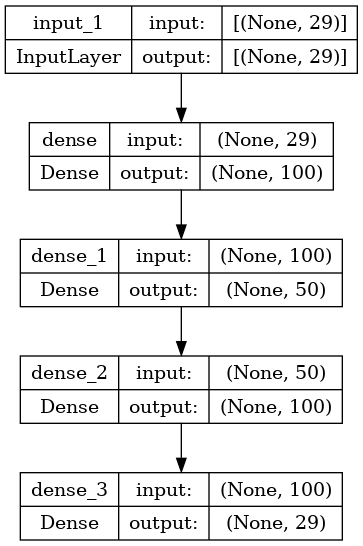

In [26]:
plot_model(autoencoder, to_file='fraud_encoder1.png',show_shapes=True,show_layer_names=True)

Train the model for 100 epochs with a batch size of 32 samples and save the best performing model to a file using ModelCheckpoint provided by Keras. 

Use the EarlyStopping callback that stops training when a monitored quantity has stopped improving.

In [27]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0) 
history = autoencoder.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, #tensorboard, 
                               earlystopping]).history

Epoch 1/100
7108/7108 [==============================] - 22s 3ms/step - loss: 0.0769 - val_loss: 0.0312
Epoch 2/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.0381 - val_loss: 0.0347


Load the model saved by `checkpointer`.

In [28]:
autoencoder = load_model('model.h5')

## Evaluation

Visualize the learning process.

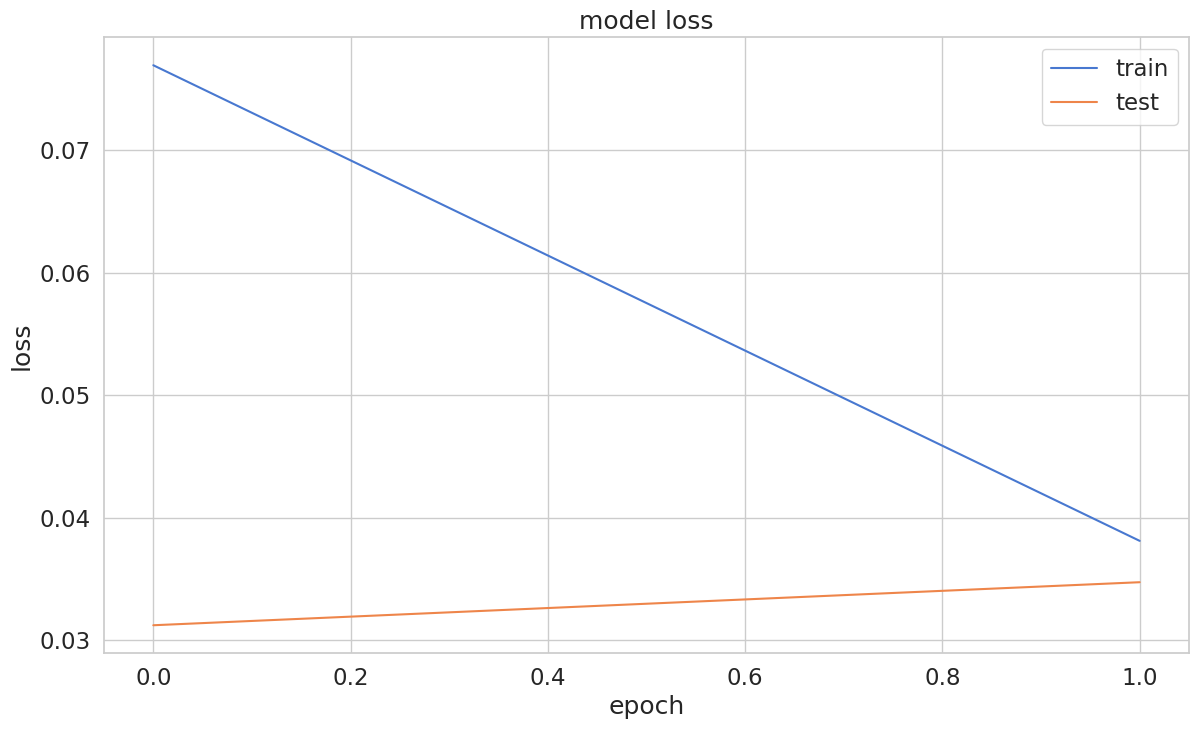

In [29]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction errors for both the train and test data converge smoothly

Calculate predictions by the autoencoder:

In [30]:
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape

1781/1781 [==============================] - 3s 1ms/step


((56962, 29), (56962, 29))

Calculate **mean squared error**.

In [31]:
testMSE = mean_squared_error(X_test.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error': testMSE,'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
263020,0.001573,0
11378,0.021103,0
147283,0.063128,0
219439,0.000917,0
36939,0.007088,0


In [32]:
error_df.shape

(56962, 2)

In [33]:
error_df.reconstruction_error.describe()

count    56962.000000
mean         0.042784
std          1.059747
min          0.000562
25%          0.001958
50%          0.003252
75%          0.006151
max         98.134076
Name: reconstruction_error, dtype: float64

## Reconstruction errors for normal transactions

Plot histogram of errors of reconstruction for normal data.

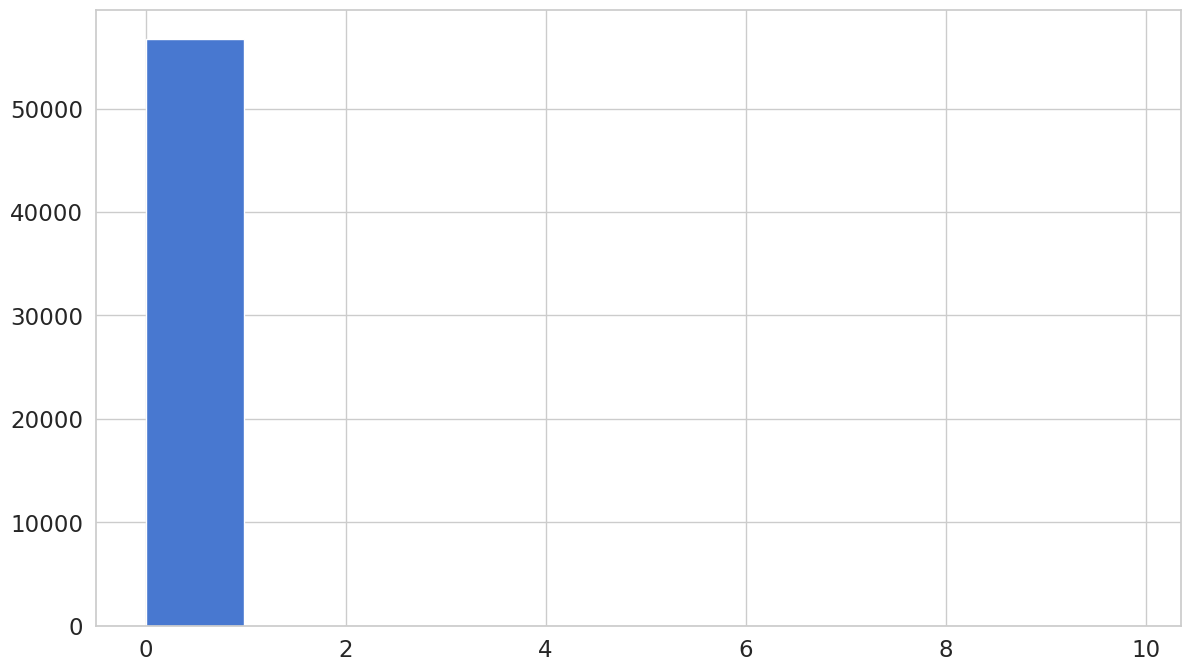

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
ax.hist(normal_error_df.reconstruction_error.values, bins=10);

## Reconstruction errors for fraudulent transactions

Compare distribution of reconstruction error for normal data and for fraudulent data.

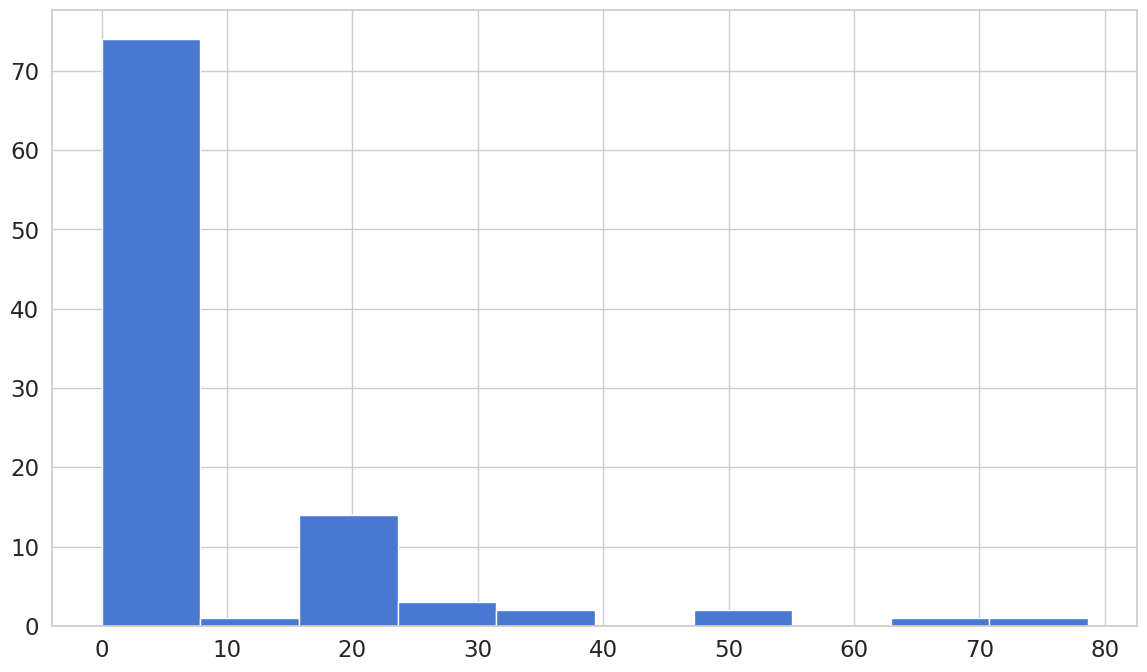

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
ax.hist(fraud_error_df.reconstruction_error.values, bins=10);

Errors of reconstruction of fraudulent data are much larger.

In [36]:
from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)

Calculate ROC curve and AUC:

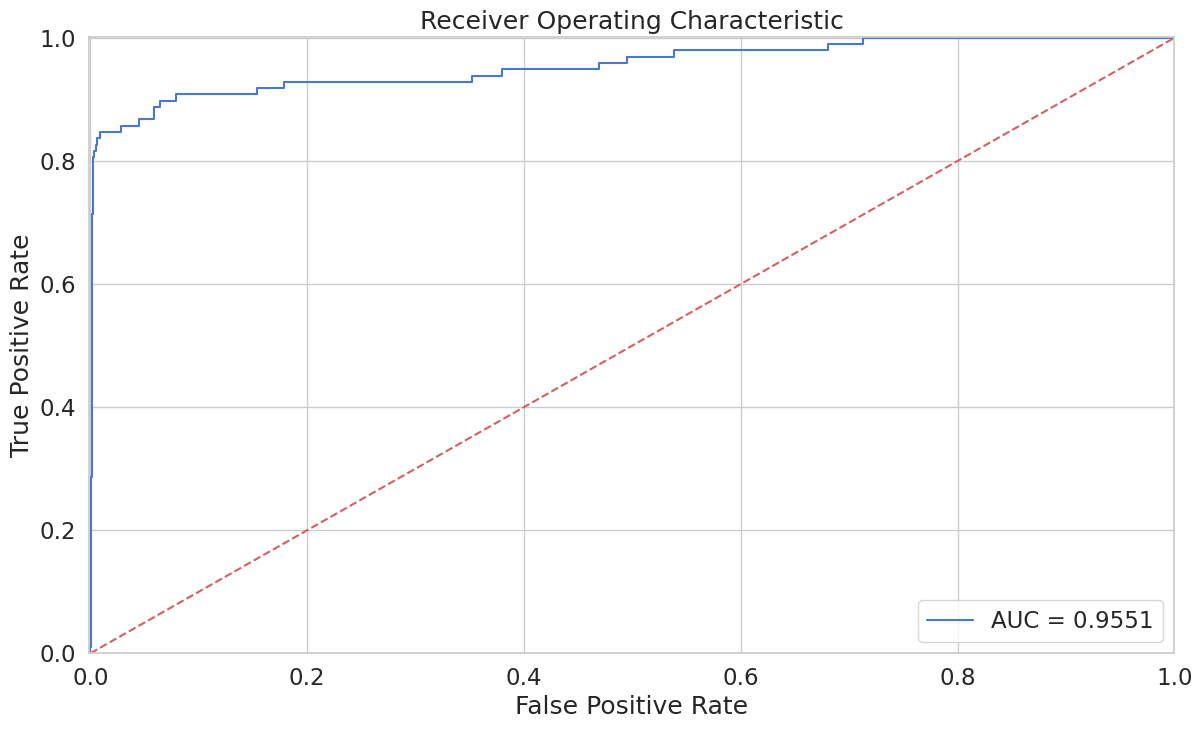

In [37]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

AUC for the autoencoder predictions is pretty high.

## Prediction

To detect fraud based on prediction MSE select a high level quantile of the MSE sample that guarantees probability of type 1 error. Select 0.995 quantile of the reconstruction error for "normal" class.

In [38]:
threshold = normal_error_df.reconstruction_error.quantile(q=0.995)
threshold

0.4073619821391366

Plot all errors, normal and fraud cases marked, and the threshold:

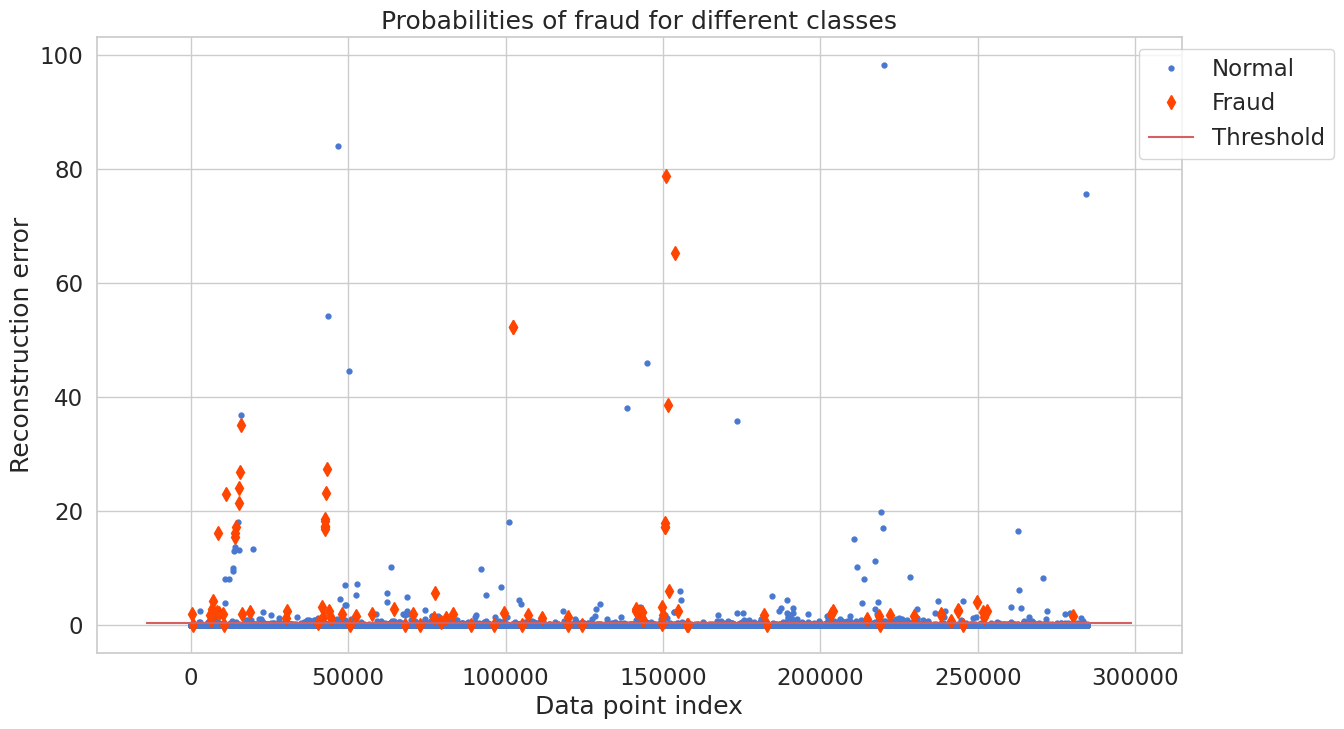

In [39]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    if name == 1:
        MarkerSize = 7
        Color = 'orangered'
        Label = 'Fraud'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.reconstruction_error, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(loc='upper left', bbox_to_anchor=(0.95, 1))
plt.title("Probabilities of fraud for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [40]:
error_df2 = error_df[error_df['reconstruction_error']<=1]
error_df2.reconstruction_error.describe()

count    56740.000000
mean         0.010523
std          0.043258
min          0.000562
25%          0.001953
50%          0.003239
75%          0.006083
max          0.998789
Name: reconstruction_error, dtype: float64

Plot Histogram for the two classes and the threshold line

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


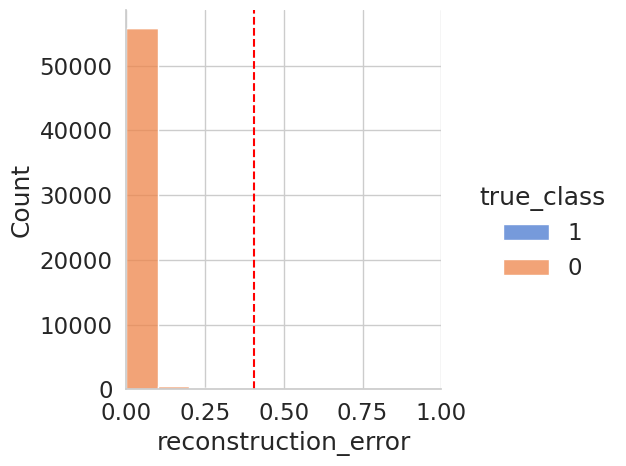

In [41]:
sns.displot(data=error_df2, x="reconstruction_error", hue="true_class", multiple="stack",bins=10,hue_order=[1,0])
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
# plt.ylim(56800,56900)
plt.xlim(0, 1)
plt.show()

Take a closer look

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


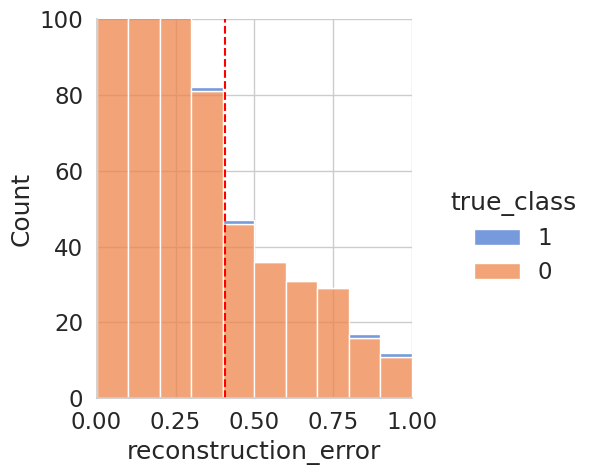

In [42]:
sns.displot(data=error_df2, x="reconstruction_error", hue="true_class", multiple="stack",bins=10,hue_order=[1,0])
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.ylim(0, 100)
plt.xlim(0, 1)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


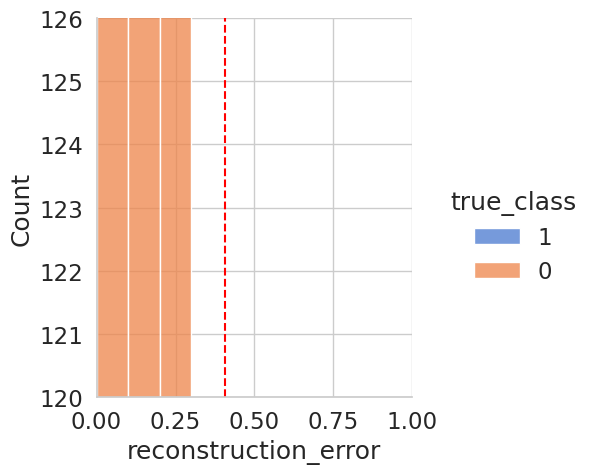

In [43]:
sns.displot(data=error_df2, x="reconstruction_error", hue="true_class", multiple="stack",bins=10,hue_order=[1,0])
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.ylim(120, 126)
plt.xlim(0, 1)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


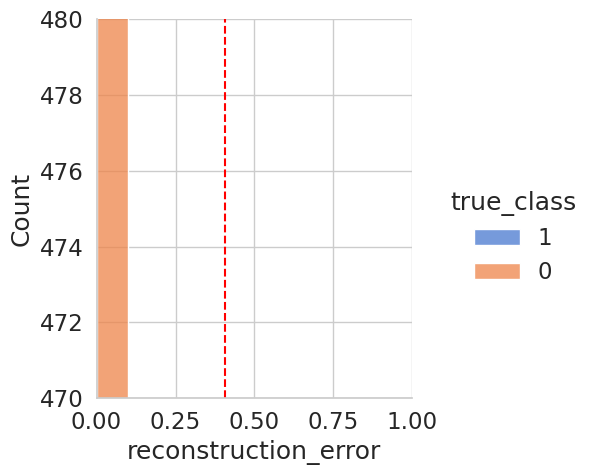

In [44]:
sns.displot(data=error_df2, x="reconstruction_error", hue="true_class", multiple="stack",bins=10,hue_order=[1,0])
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.ylim(470, 480)
plt.xlim(0, 1)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


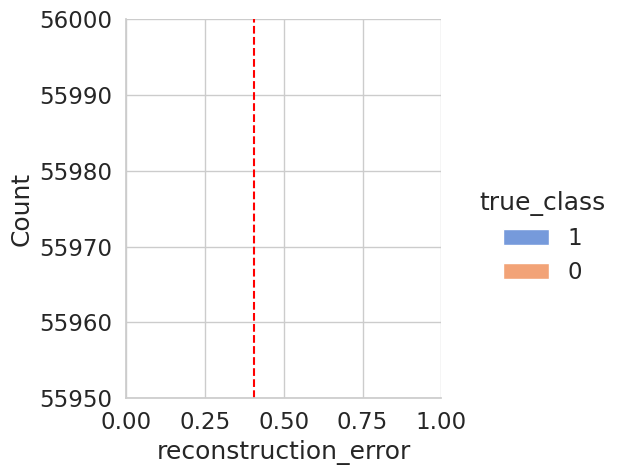

In [45]:
sns.displot(data=error_df2, x="reconstruction_error", hue="true_class", multiple="stack",bins=10,hue_order=[1,0])
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.ylim(55950, 56000)
plt.xlim(0, 1)
plt.show()

To draw more precise conclusions calculate confusion matrix:

[[56556   308]
 [   17    81]]


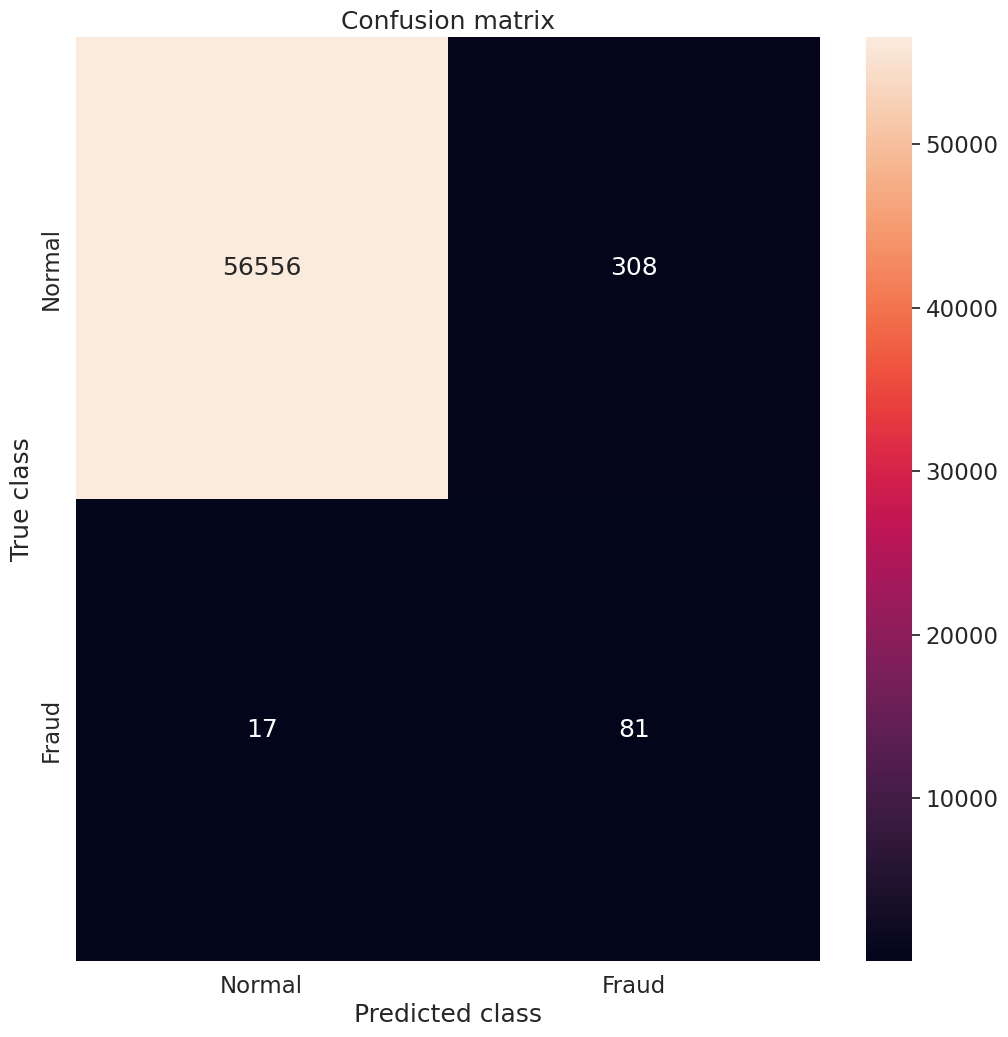

In [46]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
print(conf_matrix)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Use a different threshold

In [47]:
threshold_2 = normal_error_df.reconstruction_error.quantile(q=0.998)

[[56727   137]
 [   21    77]]


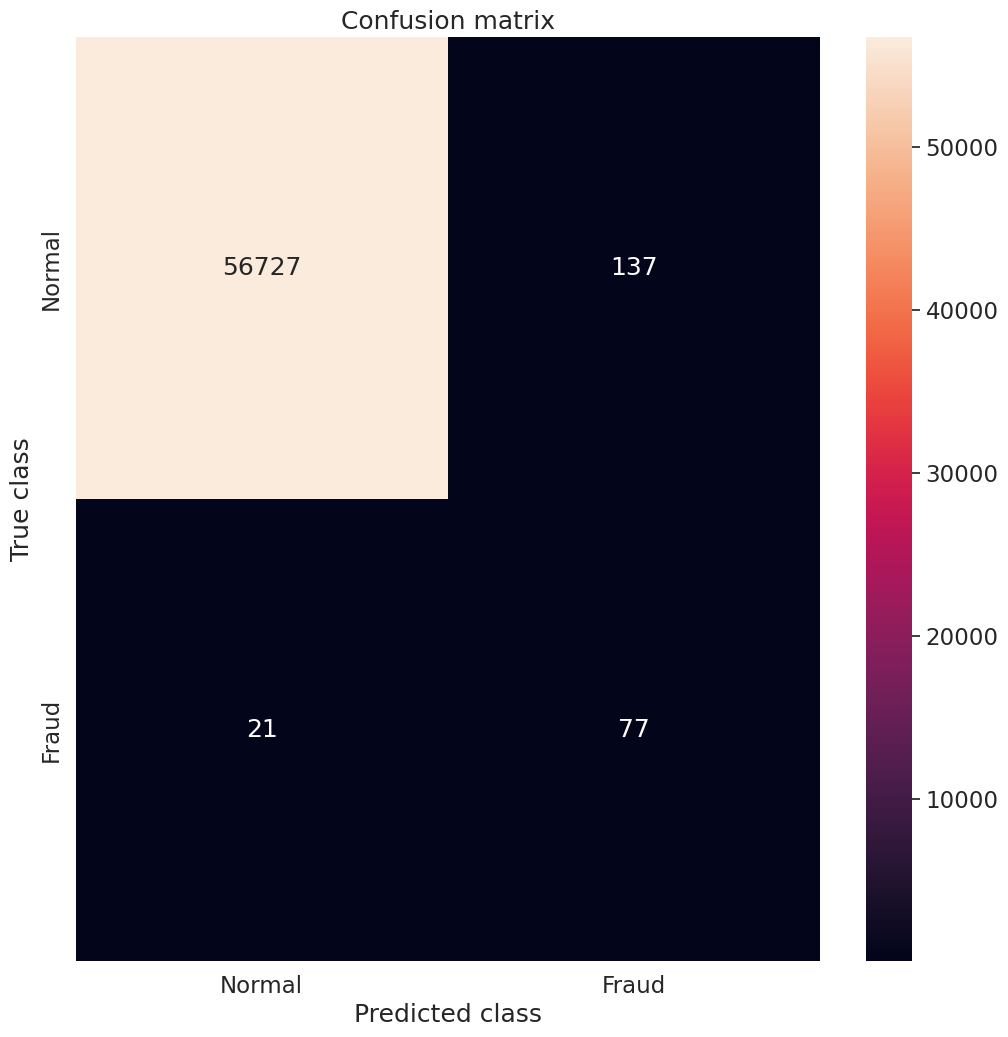

In [48]:
y_pred = [1 if e > threshold_2 else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
print(conf_matrix)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Although predicting the class using a large quantile based on the reconstruction error achieved a commendable high recall rate, it fell short in terms of precision due to a significant number of misclassified false negatives.

# 2. Supervised classification using the hidden layer of the autoencoder

Alternatively, we can leverage the information stored in the hidden layer of the pre-trained autoencoder for a supervised classification task. The hidden layer effectively captures the crucial features and essential information from the input values. By learning the most salient patterns of the data while filtering out the noise, the hidden layer becomes a valuable resource for accurate classification.

## Obtain the Latent Representations 

Let's revisit the previously trained autoencoder once more

In [49]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 100)               3000      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 29)                2929      
                                                                 
Total params: 16,079
Trainable params: 16,079
Non-trainable params: 0
_________________________________________________________________


In [50]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [51]:
autoencoder.layers[0]

In [52]:
autoencoder.layers[1]

## Split the normal and fraud of the traning data

In [53]:
x_norm = X_train[y_train == 0]
x_fraud = X_train[y_train == 1]

## Predict the hidden representation on both the norm_x and fraud_x

In [54]:
norm_hid_rep = hidden_representation.predict(x_norm)
fraud_hid_rep = hidden_representation.predict(x_fraud)

13/13 [==============================] - 0s 2ms/step


In [55]:
norm_hid_rep.shape

(227451, 50)

In [56]:
fraud_hid_rep.shape

(394, 50)

In [57]:
# def tsne_plot(x1, y1, name="graph.png"):
#     tsne = TSNE(n_components=2, random_state=0)
#     X_t = tsne.fit_transform(x1)

#     plt.figure(figsize=(12, 8))
#     plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
#     plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

#     plt.legend(loc='best');
#     plt.savefig(name);
#     plt.show();

## Append the hidden representations of fraud and normal

In [58]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
# tsne_plot(rep_x, rep_y, "latent_representation.png")

In [59]:
# # Claasifier 1
# train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, stratify=rep_y)
# clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
# pred_y = clf.predict(val_x)

# print ("")
# print ("Classification Report: ")
# print (classification_report(val_y, pred_y))

# print ("")
# print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

## Train the model

In [60]:
# Claasifier 2
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, stratify=rep_y)

# Create a logistic regression model
logreg = LogisticRegression()

# Define hyperparameters to tune
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Regularization type (L1 or L2)
    'solver': ['liblinear'],  # Solver for optimization (required for L1 regularization)
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search = GridSearchCV(logreg, param_grid, cv=10, scoring='f1', n_jobs=-1)
# grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
# grid_search = GridSearchCV(logreg, param_grid, cv=10, scoring='recall', n_jobs=-1)
# grid_search = GridSearchCV(logreg, param_grid, cv=10, scoring='precision', n_jobs=-1)
grid_search.fit(train_x, train_y)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
pred_y = best_model.predict(val_x)
accuracy = accuracy_score(val_y, pred_y)

print("Best hyperparameters:", best_params)
print("Accuracy on the test set:", accuracy)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best hyperparameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy on the test set: 0.9995786664794073


In [61]:
val_y.shape

(56962,)

[[56851    12]
 [   12    87]]


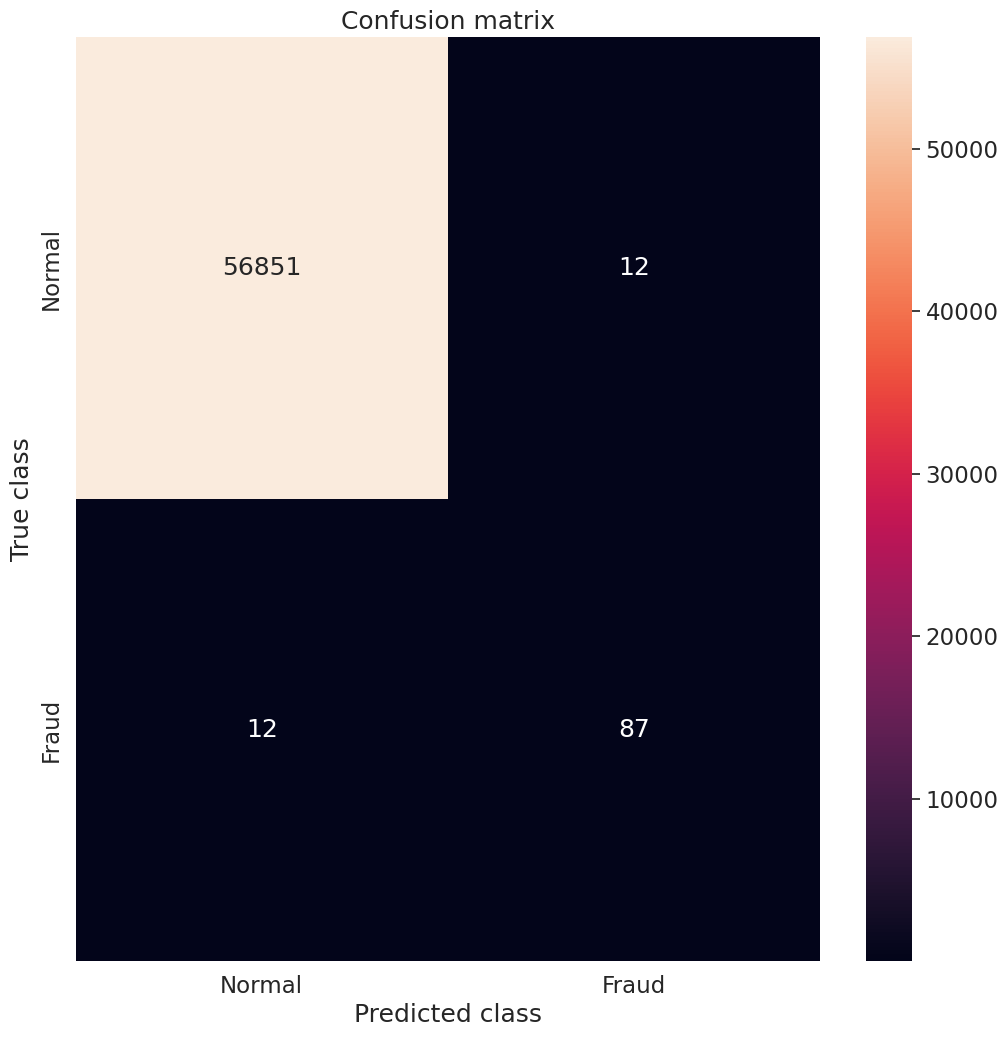

In [62]:
conf_matrix = confusion_matrix(val_y, pred_y)
print(conf_matrix)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

The model's performance on the validation set appears to be exceptional. Notably, it achieved both a high recall and a high precision, showcasing its effectiveness in accurately classifying data points

Next, let's use the model to predict on the test set

## Predict on the test set

Wrtite a helper function for prediction

In [63]:
def auto_linear_classify(hr,clf,x_test):
    x_test_hid_rep = hr.predict(x_test)
    print(x_test_hid_rep.shape)
    pred_y = clf.predict(x_test_hid_rep)
    return pred_y

Making the prediction

In [64]:
# final_pred_Y = auto_linear_classify(hidden_representation,clf,X_test)
final_pred_Y = auto_linear_classify(hidden_representation,best_model,X_test)

1781/1781 [==============================] - 3s 1ms/step
(56962, 50)


In [65]:
y_test.shape

(56962,)

[[56849    18]
 [   15    80]]


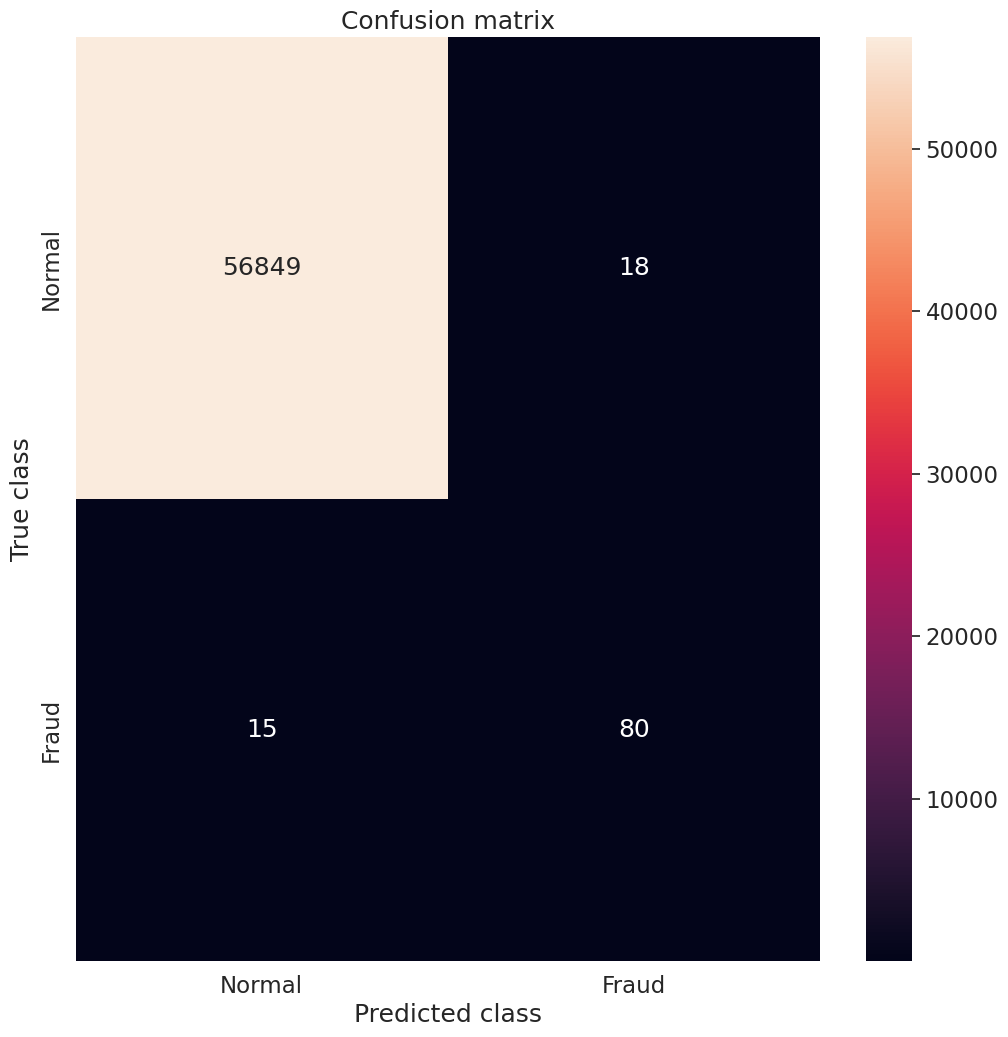

In [66]:
conf_matrix = confusion_matrix(final_pred_Y, y_test)
print(conf_matrix)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

The model also demonstrated outstanding performance on the test set, achieving remarkable levels of both recall and precision. This success further underscores its robustness and reliability in accurately classifying data points